In [1]:
%cd /content
!git clone https://github.com/theNoobSkill/w_seminar.git
%cd /content/w_seminar

/content
fatal: destination path 'w_seminar' already exists and is not an empty directory.
/content/w_seminar


In [2]:
from matplotlib import pyplot as plt

import torch
from torch.nn import Conv2d, MaxPool2d, ReLU, Linear, Sequential, Flatten
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

from main import fit, compute_accuracy

In [3]:
# Set the device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Define the transforms (standard transforms for ImageNet).
# We resize the images to have the smaller side equal to 256 and then
# take a center crop of size 224. The images are also converted to
# PyTorch tensors and normalized with the mean and standard deviation
# of the ImageNet dataset.
# The target is converted to a float tensor.
transform = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
target_transform = lambda x: torch.tensor(x, dtype=torch.float)

In [5]:
# Create a the dataset and split the validation set from the training set.
train_val_set = ImageFolder(root='data/train', transform=transform,
                            target_transform=target_transform)
train_size = int(0.75 * len(train_val_set))
val_size = len(train_val_set) - train_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])

In [6]:
# Create the dataloaders to load batches of data.
train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [7]:
# Define the model.
# AlexNet architecture but with 1 output instead of 1000.
# See `ImageNet Classification with Deep Convolutional Neural Networks
#   <https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html>`
model = Sequential(
    Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
    ReLU(inplace=True),
    MaxPool2d(kernel_size=3, stride=2),
    Conv2d(64, 192, kernel_size=5, padding=2),
    ReLU(inplace=True),
    MaxPool2d(kernel_size=3, stride=2),
    Conv2d(192, 384, kernel_size=3, padding=1),
    ReLU(inplace=True),
    Conv2d(384, 256, kernel_size=3, padding=1),
    ReLU(inplace=True),
    Conv2d(256, 256, kernel_size=3, padding=1),
    ReLU(inplace=True),
    MaxPool2d(kernel_size=3, stride=2),
    Flatten(),
    Linear(256 * 6 * 6, 4096),
    ReLU(inplace=True),
    Linear(4096, 4096),
    ReLU(inplace=True),
    Linear(4096, 1)
)

In [8]:
# As we only have 2 classes, we use the Binary Cross Entropy loss and we don't
# apply the sigmoid function to the output of the model as it is already included
# in the loss function.
loss = torch.nn.BCEWithLogitsLoss()

In [9]:
# We use the Adam optimizer that uses a first and second order momentum from
# the recent batches to make the optimization faster.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Train the model.
best_model, best_loss, train_losses, val_losses = fit(model, loss, optimizer,
                                                        train_dataloader, val_dataloader,
                                                        num_epochs=100, patience=10,
                                                        verbose=True, device=device)

Epoch 1: Val: : 100%|██████████| 25/25 [00:30<00:00,  1.20s/it, loss=0.614]
Epoch 1/100: Train Loss: 0.6567 Val Loss: 0.6073
Epoch 2: Val: : 100%|██████████| 25/25 [00:31<00:00,  1.27s/it, loss=0.439]
Epoch 2/100: Train Loss: 0.5575 Val Loss: 0.4932
Epoch 3: Val: : 100%|██████████| 25/25 [00:29<00:00,  1.18s/it, loss=0.381]
Epoch 3/100: Train Loss: 0.4690 Val Loss: 0.4688
Epoch 4: Val: : 100%|██████████| 25/25 [00:29<00:00,  1.19s/it, loss=0.379]
Epoch 4/100: Train Loss: 0.4070 Val Loss: 0.4819
Epoch 5: Val: : 100%|██████████| 25/25 [00:29<00:00,  1.19s/it, loss=0.482]
Epoch 5/100: Train Loss: 0.3596 Val Loss: 0.4133
Epoch 6: Val: : 100%|██████████| 25/25 [00:28<00:00,  1.16s/it, loss=0.325]
Epoch 6/100: Train Loss: 0.3187 Val Loss: 0.3504
Epoch 7: Val: : 100%|██████████| 25/25 [00:29<00:00,  1.20s/it, loss=0.27]
Epoch 7/100: Train Loss: 0.2800 Val Loss: 0.3453
Epoch 8: Val: : 100%|██████████| 25/25 [00:29<00:00,  1.17s/it, loss=0.396]
Epoch 8/100: Train Loss: 0.2331 Val Loss: 0.3695
E

In [11]:
# Create the test set and dataloader.
test_set = ImageFolder(root='data/test', transform=transform, target_transform=target_transform)
test_dataloader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
# Compute the accuracy on the test set.
print(f'Accuracy: {compute_accuracy(best_model, test_dataloader, device=device) * 100:.2f}%')

Accuracy: 88.00%


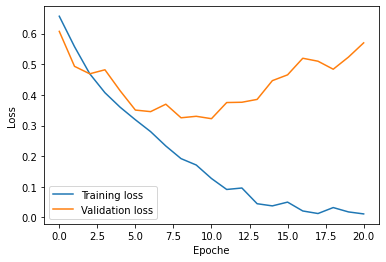

In [13]:
# Plot the training and validation losses.
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend()
plt.savefig('losses.png')
plt.show()

In [14]:
# Save the model.
torch.save(best_model.to('cpu').state_dict(), 'model.pt')